In [ ]:
# Autor: Martin Bublavý [xbubla02]

import matplotlib.pyplot as plt
from QuestionProcessor import QuestionProcessor
from json_types.Answer import Answer
from json_types.Video import Video
from json_types.EModel import EModel
from typing import List, Tuple

question_processor = QuestionProcessor("./export.json")  

General Questions: 6
General Answers: 210


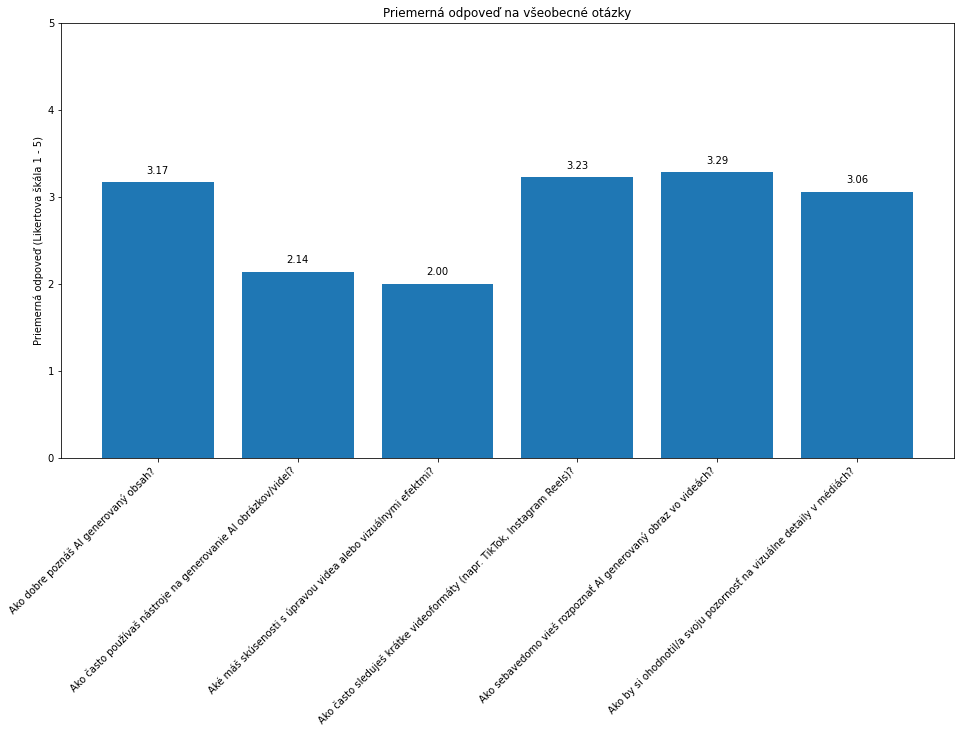

In [163]:
# Evaluate the general questions and answers

general_questions_and_answers = question_processor.get_general_questions_and_answers()
question_texts = []
question_averages = []

for qa in general_questions_and_answers:
    question = qa[0]
    answers = qa[1]

    values = [a['answer'] for a in answers]
    if values:
        average = sum(values) / len(values)
        question_averages.append(average)
        question_texts.append(question['titleSk'])
        
        
plt.figure(figsize=(16, 8))
bars = plt.bar(question_texts, question_averages)
plt.title("Priemerná odpoveď na všeobecné otázky")
plt.ylabel("Priemerná odpoveď (Likertova škála 1 - 5)")
plt.ylim(0, 5)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, f"{yval:.2f}", ha='center')

plt.show()

In [ ]:
def calculate_ranking_avg(answers: list[Answer], videos: List[Video], original_video_name: str = None) -> List[Tuple[str, float]]:
    """
    Calculate the average ranking for a given question and its answers.
    """
    # Create a dictionary to store the sum of ranks and the count of answers for each EModel
    rank_sums = {model.value: 0 for model in EModel if model != EModel.NONE}
    
    if original_video_name is not None:
        print(f"Filtering answers for original video name: {original_video_name}")
        # Filter out answers that are not related to the specified original video name
        related_video_ids = [video['id'] for video in videos if "originalVideoName" in video and video['originalVideoName'] == original_video_name]
        answers = [answer for answer in answers if all(video_id in related_video_ids for video_id in answer['answer'])]
        
        if len(answers) == 0:
            raise ValueError(f"No answers found for original video name: {original_video_name}")

    for answer in answers:
        ranking: List[str] = answer['answer']	

        if ranking is None:
            raise ValueError("Ranking is None")

        for video_id in ranking:
            video = next((v for v in videos if v['id'] == video_id), None)
            
            if video is None:
                raise ValueError(f"Video with ID {video_id} not found in videos list")

            rank_sums[video['model']] += ranking.index(video_id) + 1  # Add 1 to convert from 0-based index to rank
          
    # Calculate the average rank for each EModel
    rank_averages = []
    for model, sum_ranks in rank_sums.items():
        avg_rank = round(sum_ranks / len(answers), 2) if sum_ranks > 0 else 0
        rank_averages.append((model, avg_rank))
           
    return rank_averages

def sum_choice_answers(answers: list[Answer], videos: List[Video], original_video_name: str = None) -> dict[str, int]:
    sums = {model.value: 0 for model in EModel if model != EModel.NONE}
    
    if original_video_name is not None:
        print(f"Filtering answers for original video name: {original_video_name}")
        # Filter out answers that are not related to the specified original video name
        related_video_ids = [video['id'] for video in videos if "originalVideoName" in video and video['originalVideoName'] == original_video_name]
        answers = [answer for answer in answers if all(video_id in related_video_ids for video_id in answer['answer'])]
        
        if len(answers) == 0:
            raise ValueError(f"No answers found for original video name: {original_video_name}")
    
    for answer in answers:
        chosen_video_id: str = answer['answer'][0]
        
        if chosen_video_id is None:
            raise ValueError("Chosen video ID is None")
        
        video = next((v for v in videos if v['id'] == chosen_video_id), None)
        
        if video is None:
            raise ValueError(f"Video with ID {chosen_video_id} not found in videos list")
        
        sums[video['model']] += 1  # Increment the count
        
    return sums

def plot_ranking_avg(ranking_avg: List[Tuple[str, float]], question_text: str) -> None:
    plt.figure(figsize=(12, 6))
    plt.bar([model for model, _ in ranking_avg], [avg for _, avg in ranking_avg])
    plt.title(question_text)
    plt.xlabel("Model")
    plt.ylabel("Priemerné hodnotenie (1 - 5)")
    plt.ylim(0, 5)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
def plot_choice_sums(sums: dict[str, int], question_text: str) -> None:
    plt.figure(figsize=(12, 6))
    bars = plt.bar(sums.keys(), sums.values())

    max_height = max(sums.values())
    plt.ylim(0, max_height * 1.15)  # Add 15% headroom

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.5, 
            str(int(height)), 
            ha='center', 
            va='bottom', 
            fontsize=9
        )

    plt.title(question_text)
    plt.xlabel("Model")
    plt.ylabel("Počet výberov (viac je lepšie)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
def process_ranking_video_question(question_ids: List[str], original_video_name: str = None) -> None:
    """
    Process a video question and plot the average ranking for each EModel.
    """
    prompt_allignment_q_a = question_processor.get_questions_by_ids_and_answers(question_ids)
    question_videos = question_processor.get_videos_by_question_ids(question_ids)
    all_answers = [
        answer
        for _, answers in prompt_allignment_q_a
        for answer in answers
    ]

    rank_avgs = calculate_ranking_avg(all_answers, question_videos, original_video_name)
    print(rank_avgs)
    plot_ranking_avg(rank_avgs, prompt_allignment_q_a[0][0]['titleSk'])
    
    return rank_avgs
 
def process_choice_video_question(question_ids: List[str], original_video_name: str = None) -> None:
    prompt_allignment_q_a = question_processor.get_questions_by_ids_and_answers(question_ids)
    question_videos = question_processor.get_videos_by_question_ids(question_ids)
    all_answers = [
		answer
		for _, answers in prompt_allignment_q_a
		for answer in answers
	]
    
    sums = sum_choice_answers(all_answers, question_videos, original_video_name)
    print(sums)
 
    plot_choice_sums(sums, prompt_allignment_q_a[0][0]['titleSk'])
    
    return sums

In [165]:
original_video_name = None

[('Video-P2P', 2.21), ('Video-P2P-EI', 2.16), ('Video-P2P-EI-Plus', 2.19), ('Tune-A-Video', 3.44)]


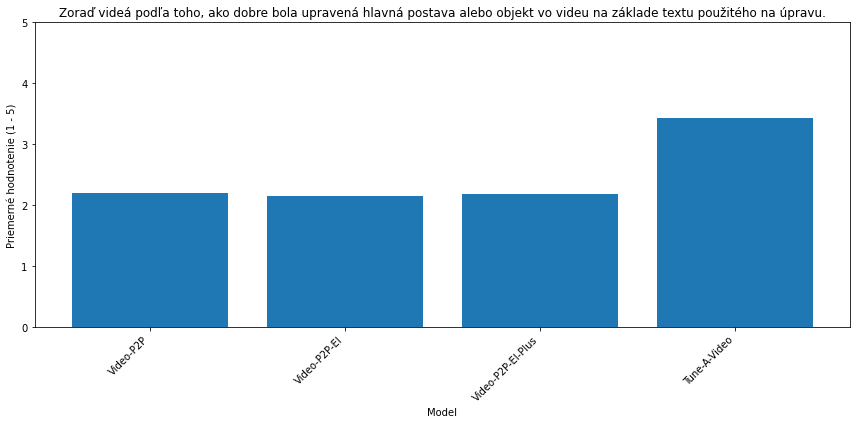

In [166]:
# Evaluate first video question (prompt allignment)
question_ids = ["dGltjzC0vpeHDQwjXgf9", "0tdl9jgCfhZ3423laywU", "BKeqDnoUW2y1wYAL93Zr", "TsLIUdhojKBv4tsnd4fQ", "6EleqLgCAfeWORTF3iDa", "ZvPQBKYx2HeUnJMMwlbg"]
prompt_allign_ranks = process_ranking_video_question(question_ids, original_video_name=original_video_name)

[('Video-P2P', 2.33), ('Video-P2P-EI', 2.2), ('Video-P2P-EI-Plus', 2.25), ('Tune-A-Video', 3.22)]


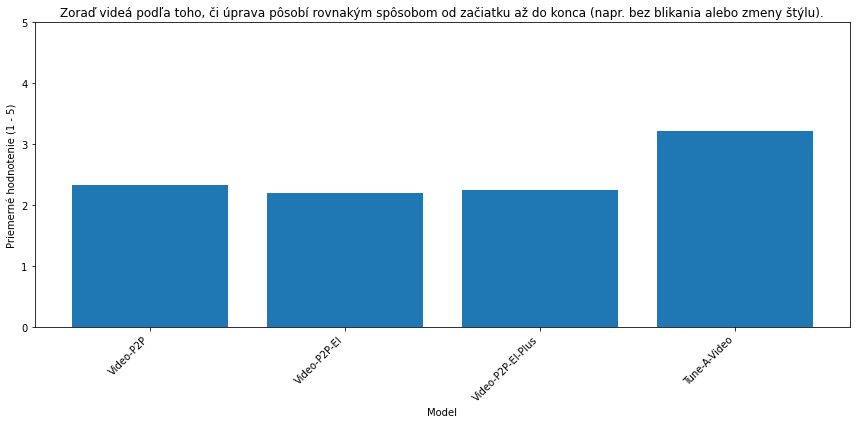

In [167]:
# Evaluate second video question (temporal consistency)
question_ids = ["Sb0CCXKj1iwNIU0E8Yyr", "EvfyNU2tCTQJL6H8G1kW", "1Mo1VObX8bT6daW1AVI7", "Xzmq0YzcwNWxBzEuZjDm", "9lAoazdxfFT7QxI7lriJ", "IXdbiCSkBZEIO90dbt9b"]
temporal_consistency_ranks = process_ranking_video_question(question_ids, original_video_name=original_video_name)

{'Video-P2P': 46, 'Video-P2P-EI': 55, 'Video-P2P-EI-Plus': 75, 'Tune-A-Video': 34}


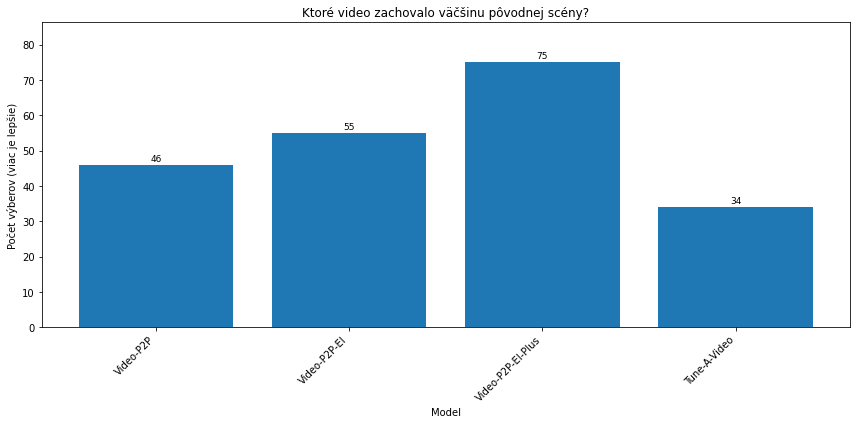

In [168]:
# Evaluate third video question (scene preservation)
question_ids = ["LW3dqYChtj97M9AidV6z", "QbDnCbK8CludE7GCHxuy", "8NcczHcM0xE7RsV6lUT1", "LMHqQKWzy5movEpEL2gi", "Q5JjWFEcA56RX3XRI441", "beNtk5ZW2b09o980RJPk"]
scene_preservation_sums = process_choice_video_question(question_ids, original_video_name=original_video_name)

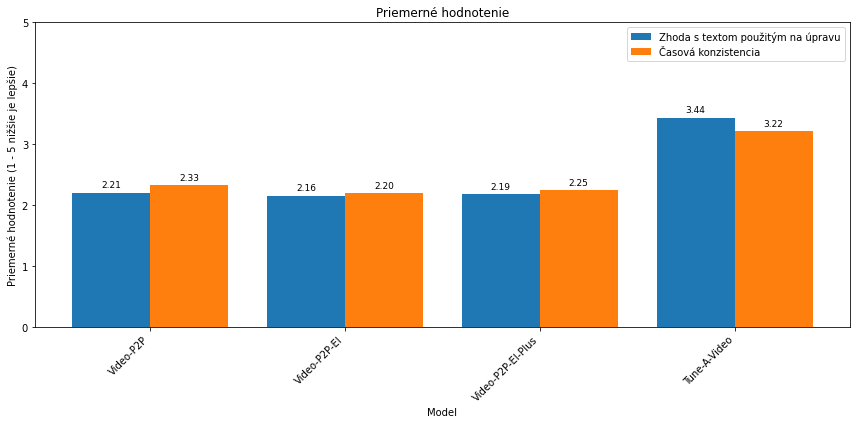

In [169]:
# Join the ranking results into a single bar chart with mutliple bars next to each other and a legend
def plot_combined_ranking_avg(ranking_avgs: List[List[Tuple[str, float]]], question_texts: List[str]) -> None:
    num_questions = len(ranking_avgs)
    models = [model for model, _ in ranking_avgs[0]]
    x = np.arange(len(models))  # Base x locations for the groups
    bar_width = 0.8 / num_questions  # Width of each bar

    plt.figure(figsize=(12, 6))

    for i, rank_avg in enumerate(ranking_avgs):
        values = [avg for _, avg in rank_avg]
        bars = plt.bar(x + i * bar_width, values, width=bar_width, label=question_texts[i])
        
        # Add text labels to each bar
        for bar, value in zip(bars, values):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{value:.2f}",
                    ha='center', va='bottom', fontsize=9)

    plt.title("Priemerné hodnotenie")
    plt.xlabel("Model")
    plt.ylabel("Priemerné hodnotenie (1 - 5 nižšie je lepšie)")
    plt.ylim(0, 5)
    plt.xticks(x + bar_width * (num_questions - 1) / 2, models, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
 
plot_combined_ranking_avg([prompt_allign_ranks, temporal_consistency_ranks], ["Zhoda s textom použitým na úpravu", "Časová konzistencia"])